Loading MNIST...
Applying PCA to 50 dims...
Fitting single Gaussians per class...
[Gaussian] Test accuracy: 0.9631


C:\Users\DELL\AppData\Local\Temp\ipykernel_19604\2604909725.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs[i] = np.trapz(tpr[i], fpr[i])  # AUC via trapezoidal rule
C:\Users\DELL\AppData\Local\Temp\ipykernel_19604\2604909725.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs[i] = np.trapz(tpr[i], fpr[i])  # AUC via trapezoidal rule
C:\Users\DELL\AppData\Local\Temp\ipykernel_19604\2604909725.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs[i] = np.trapz(tpr[i], fpr[i])  # AUC via trapezoidal rule
C:\Users\DELL\AppData\Local\Temp\ipykernel_19604\2604909725.py:104: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.i

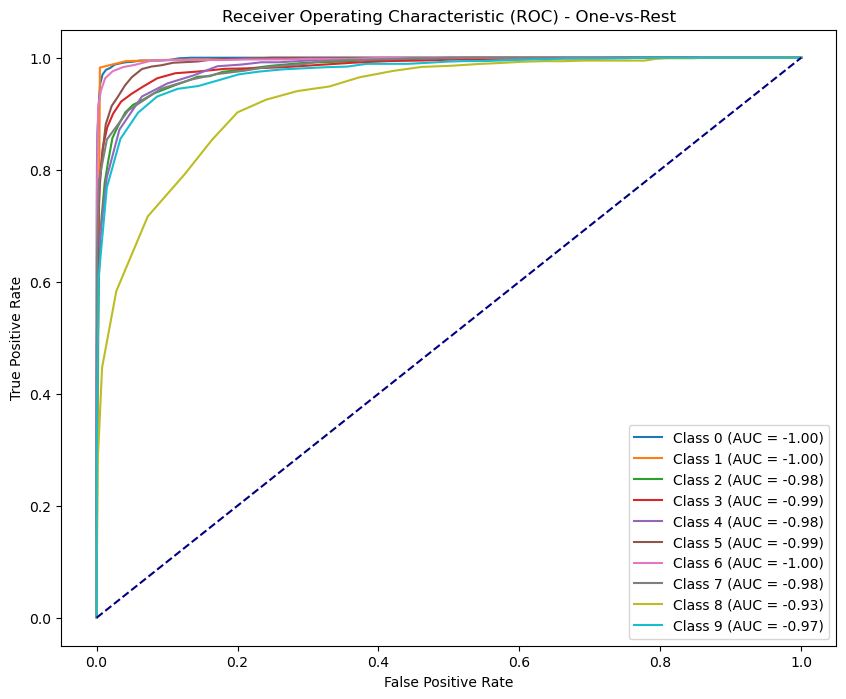

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.stats import multivariate_normal as mvn

# ----------- Config ----------
SEED = 42
USE_PCA = True
PCA_DIM = 50            
COV_EPS = 1e-4         
TEST_SIZE = 10000       

print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(int)

X_train, y_train = X[:-TEST_SIZE], y[:-TEST_SIZE]
X_test, y_test = X[-TEST_SIZE:], y[-TEST_SIZE:]

if USE_PCA:
    print(f"Applying PCA to {PCA_DIM} dims...")
    pca = PCA(n_components=PCA_DIM, random_state=SEED, svd_solver='randomized', whiten=False)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

classes = np.unique(y_train)
K = len(classes)
priors = np.array([(y_train == k).mean() for k in classes])
log_priors = np.log(priors + 1e-12)

print("Fitting single Gaussians per class...")
gauss_params = {} 
for k in classes:
    Xk = X_train[y_train == k]
    mu_k = Xk.mean(axis=0)
    S_k = np.cov(Xk, rowvar=False)
    S_k = S_k + COV_EPS * np.eye(S_k.shape[0]) 
    gauss_params[k] = (mu_k, S_k)

def gaussian_loglik_all_classes(X_batch):
    n = X_batch.shape[0]
    LL = np.zeros((n, K), dtype=np.float64)
    for idx, k in enumerate(classes):
        mu_k, S_k = gauss_params[k]
        LL[:, idx] = mvn.logpdf(X_batch, mean=mu_k, cov=S_k, allow_singular=False)
    return LL

# Predict 
LL_gauss_test = gaussian_loglik_all_classes(X_test)
logpost_gauss_test = LL_gauss_test + log_priors  
yhat_gauss = classes[np.argmax(logpost_gauss_test, axis=1)]
acc_gauss = accuracy_score(y_test, yhat_gauss)
print(f"[Gaussian] Test accuracy: {acc_gauss:.4f}")

scores_gauss = logpost_gauss_test  

def compute_roc_curve(y_true, scores, num_classes=10):
    fpr = {}
    tpr = {}
    thresholds = {}
    aucs = {}

    for i in range(num_classes):
        true_binary = (y_true == i).astype(int)
        fpr_list = []
        tpr_list = []
        thresholds_list = []

        # Get predicted scores for class i
        class_scores = scores[:, i]

        thresholds_range = np.linspace(np.min(class_scores), np.max(class_scores), num=100)

        for threshold in thresholds_range:
            predicted_binary = (class_scores >= threshold).astype(int)

            TP = np.sum((true_binary == 1) & (predicted_binary == 1))
            TN = np.sum((true_binary == 0) & (predicted_binary == 0))
            FP = np.sum((true_binary == 0) & (predicted_binary == 1))
            FN = np.sum((true_binary == 1) & (predicted_binary == 0))

            TPR = TP / (TP + FN) if TP + FN > 0 else 0
            FPR = FP / (FP + TN) if FP + TN > 0 else 0

            tpr_list.append(TPR)
            fpr_list.append(FPR)
            thresholds_list.append(threshold)

        fpr[i] = np.array(fpr_list)
        tpr[i] = np.array(tpr_list)
        thresholds[i] = np.array(thresholds_list)

        aucs[i] = np.trapz(tpr[i], fpr[i]) 

    return fpr, tpr, aucs

def plot_roc_curves(fpr, tpr, aucs, num_classes=10):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
    plt.legend(loc='lower right')
    plt.show()

fpr, tpr, aucs = compute_roc_curve(y_test, scores_gauss)

plot_roc_curves(fpr, tpr, aucs)


Loading MNIST...
Applying PCA to 10 dims...


C:\Users\DELL\AppData\Local\Temp\ipykernel_7372\2883133542.py:119: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_likelihoods[i, k] = np.log(gaussian_pdf(X[i:i+1], means[k], covariances[k])) + np.log(weights[k])
C:\Users\DELL\AppData\Local\Temp\ipykernel_7372\2883133542.py:119: RuntimeWarning: divide by zero encountered in log
  log_likelihoods[i, k] = np.log(gaussian_pdf(X[i:i+1], means[k], covariances[k])) + np.log(weights[k])


[GMM] Test accuracy: 0.1730


C:\Users\DELL\AppData\Local\Temp\ipykernel_7372\2883133542.py:186: RuntimeWarning: divide by zero encountered in log
  logpost_gmm_test = np.array([np.log(gaussian_pdf(X_test, means[k], covariances[k])) + np.log(weights[k]) for k in range(len(means))]).T
C:\Users\DELL\AppData\Local\Temp\ipykernel_7372\2883133542.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs[i] = np.trapz(tpr[i], fpr[i])  # AUC via trapezoidal rule
C:\Users\DELL\AppData\Local\Temp\ipykernel_7372\2883133542.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs[i] = np.trapz(tpr[i], fpr[i])  # AUC via trapezoidal rule
C:\Users\DELL\AppData\Local\Temp\ipykernel_7372\2883133542.py:168: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  aucs

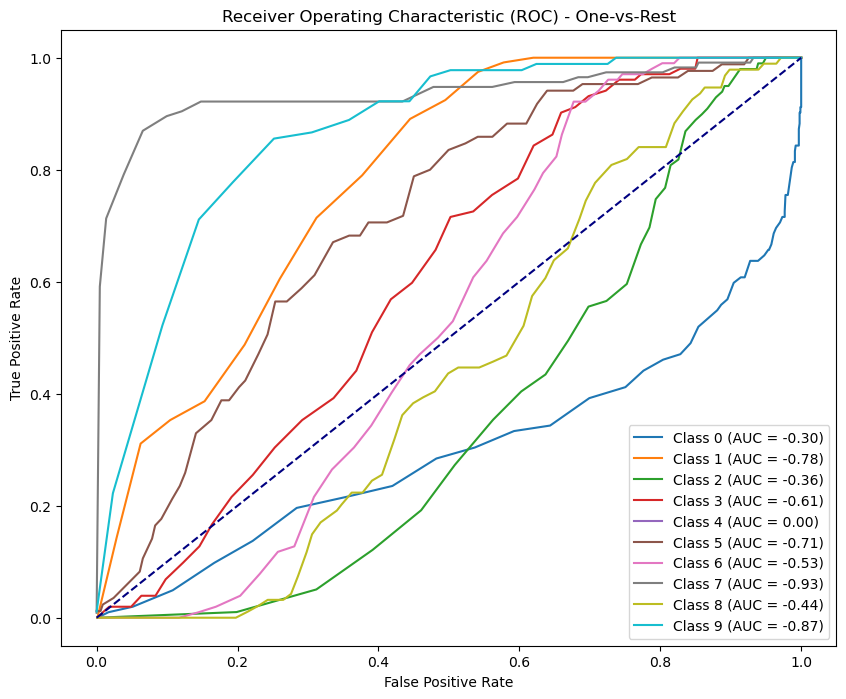

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

# ----------- Config ----------
SEED = 42
USE_PCA = True
PCA_DIM = 10             # Reduce PCA dimensions to speed up fitting
COV_EPS = 1e-4         
TEST_SIZE = 1000         # Reduce the test size for faster testing

print("Loading MNIST...")
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype(np.float32) / 255.0
y = mnist.target.astype(int)

X_train, y_train = X[:-TEST_SIZE], y[:-TEST_SIZE]
X_test, y_test = X[-TEST_SIZE:], y[-TEST_SIZE:]

if USE_PCA:
    print(f"Applying PCA to {PCA_DIM} dims...")
    pca = PCA(n_components=PCA_DIM, random_state=SEED, svd_solver='randomized', whiten=False)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

#  GMM Model 
def initialize_gmm(X, n_components):
    n_samples, n_features = X.shape
    means = np.random.randn(n_components, n_features) 
    covariances = np.array([np.eye(n_features) for _ in range(n_components)]) 
    weights = np.ones(n_components) / n_components  
    return means, covariances, weights

def gaussian_pdf(X, mean, covariance):
    n_features = X.shape[1]
    diff = X - mean
    inv_cov = np.linalg.inv(covariance)
    det_cov = np.linalg.det(covariance)
    norm_const = 1 / ((2 * np.pi) ** (n_features / 2) * (det_cov) ** 0.5)
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    return norm_const * np.exp(exponent)

def e_step(X, means, covariances, weights):
    n_samples, n_features = X.shape
    n_components = len(means)
    responsibilities = np.zeros((n_samples, n_components))
    
    for k in range(n_components):
        resp = gaussian_pdf(X, means[k], covariances[k]) * weights[k]
        responsibilities[:, k] = resp
    
    responsibilities = responsibilities / responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(X, responsibilities):
    n_samples, n_features = X.shape
    n_components = responsibilities.shape[1]
    
    weights = responsibilities.sum(axis=0) / n_samples
    means = (responsibilities.T @ X) / responsibilities.sum(axis=0)[:, np.newaxis]
    covariances = np.zeros((n_components, n_features, n_features))
    
    for k in range(n_components):
        diff = X - means[k]
        covariances[k] = (responsibilities[:, k][:, np.newaxis] * diff).T @ diff / responsibilities[:, k].sum()
        covariances[k] += COV_EPS * np.eye(n_features)  # Add small ridge for stability
    
    return means, covariances, weights

def log_likelihood(X, means, covariances, weights):
    n_samples = X.shape[0]
    n_components = len(means)
    log_likelihood = 0
    
    for i in range(n_samples):
        component_likelihoods = np.array([gaussian_pdf(X[i:i+1], means[k], covariances[k]) * weights[k] for k in range(n_components)])
        log_likelihood += np.log(np.sum(component_likelihoods))
    
    return log_likelihood

def fit_gmm(X, n_components, n_iter=20, tol=1e-6):  # Reduce number of iterations for faster computation
    means, covariances, weights = initialize_gmm(X, n_components)
    prev_log_likelihood = 0
    
    for i in range(n_iter):
        responsibilities = e_step(X, means, covariances, weights)
        
        means, covariances, weights = m_step(X, responsibilities)
        
        log_likelihood_value = log_likelihood(X, means, covariances, weights)
        
        if np.abs(log_likelihood_value - prev_log_likelihood) < tol:
            print(f"Converged at iteration {i+1}")
            break
        prev_log_likelihood = log_likelihood_value
    
    return means, covariances, weights

n_components = 10
means, covariances, weights = fit_gmm(X_train, n_components)


def gmm_predict(X, means, covariances, weights):
    n_samples = X.shape[0]
    log_likelihoods = np.zeros((n_samples, len(means)))
    
    for i in range(n_samples):
        for k in range(len(means)):
            log_likelihoods[i, k] = np.log(gaussian_pdf(X[i:i+1], means[k], covariances[k])) + np.log(weights[k])
    
    return np.argmax(log_likelihoods, axis=1)

# Predict
predictions_gmm = gmm_predict(X_test, means, covariances, weights)

#accuracy
acc_gmm = accuracy_score(y_test, predictions_gmm)
print(f"[GMM] Test accuracy: {acc_gmm:.4f}")


def compute_roc_curve(y_true, scores, num_classes=10):
    fpr = {}
    tpr = {}
    thresholds = {}
    aucs = {}

    for i in range(num_classes):
        true_binary = (y_true == i).astype(int)
        fpr_list = []
        tpr_list = []
        thresholds_list = []

        class_scores = scores[:, i]

        thresholds_range = np.linspace(np.min(class_scores), np.max(class_scores), num=100)

        for threshold in thresholds_range:
            predicted_binary = (class_scores >= threshold).astype(int)

            TP = np.sum((true_binary == 1) & (predicted_binary == 1))
            TN = np.sum((true_binary == 0) & (predicted_binary == 0))
            FP = np.sum((true_binary == 0) & (predicted_binary == 1))
            FN = np.sum((true_binary == 1) & (predicted_binary == 0))

            TPR = TP / (TP + FN) if TP + FN > 0 else 0
            FPR = FP / (FP + TN) if FP + TN > 0 else 0

            tpr_list.append(TPR)
            fpr_list.append(FPR)
            thresholds_list.append(threshold)

        fpr[i] = np.array(fpr_list)
        tpr[i] = np.array(tpr_list)
        thresholds[i] = np.array(thresholds_list)

        aucs[i] = np.trapz(tpr[i], fpr[i])  
    return fpr, tpr, aucs


def plot_roc_curves(fpr, tpr, aucs, num_classes=10):
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {aucs[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - One-vs-Rest')
    plt.legend(loc='lower right')
    plt.show()

logpost_gmm_test = np.array([np.log(gaussian_pdf(X_test, means[k], covariances[k])) + np.log(weights[k]) for k in range(len(means))]).T

#  ROC curves 
fpr_gmm, tpr_gmm, aucs_gmm = compute_roc_curve(y_test, logpost_gmm_test)

# Plot the ROC 
plot_roc_curves(fpr_gmm, tpr_gmm, aucs_gmm)

## MLE is better and faster.

## GMM is great for experimentation and exploration when you're sure that classes have multiple patterns inside them, and you're okay with the extra time and tuning involved.